In [1]:
!pip install sagemaker==1.72.0 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import os
import ast
import json
import numpy as np
import pandas as pd
import source
import math

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.estimator import SKLearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import Audio
sound_file = './sound/beep.wav'

import warnings
warnings.filterwarnings('ignore')

session = sagemaker.Session()
role = get_execution_role()

<h2> Data Processing </h2>

ROI is calculated using next price because we are trying to predict future ROI using the data from current time period.
Referred to https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v1c_xgboost.ipynb & https://towardsdatascience.com/cryptocurrency-price-prediction-using-lstms-tensorflow-for-hackers-part-iii-264fcdbccd3f

In [223]:
DATA_DIR = './data'

In [224]:
data = pd.read_csv(os.path.join(DATA_DIR, 'crypto-historical-data.csv'), 
                   parse_dates=['time'], 
                   index_col=0, 
                   keep_default_na=False,
                   header=0,
                   names=['market_cap', 'name', 'price', 'sym', 'time', 'volume'])

data.sort_values(by=['sym', 'time'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [225]:
data['rank'] = data.groupby("time")["market_cap"] \
                    .rank("dense", ascending=False) \
                    .astype(int)

data['market_share'] = data.groupby('time')["market_cap"] \
                    .apply(lambda x: x/float(x.sum()))

data['age'] = data.groupby(['sym'])["time"] \
                    .apply(lambda x: x - min(x)) \
                    .dt.days + 1

previous_price = data.groupby(['sym'])['price'].shift(-1)
data['roi'] = data['price']/previous_price - 1

In [226]:
data[data['sym'] == 'ETH'].head(10)

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
224231,167911000.0,Ethereum,0.753325,ETH,2015-08-08,674188.0,4,0.034732,1,0.073270
224232,42637600.0,Ethereum,0.701897,ETH,2015-08-09,532170.0,4,0.009641,2,-0.009247
224233,43130000.0,Ethereum,0.708448,ETH,2015-08-10,405283.0,4,0.009581,3,-0.337899
224234,42796500.0,Ethereum,1.070000,ETH,2015-08-11,1463100.0,4,0.009541,4,-0.122951
224235,64018400.0,Ethereum,1.220000,ETH,2015-08-12,2150620.0,4,0.013904,5,-0.333333
224236,73935400.0,Ethereum,1.830000,ETH,2015-08-13,4068680.0,4,0.016312,6,0.000000
224237,109594000.0,Ethereum,1.830000,ETH,2015-08-14,4637030.0,4,0.024201,7,0.082840
224238,109160000.0,Ethereum,1.690000,ETH,2015-08-15,2554360.0,4,0.023926,8,0.076433
224239,102028000.0,Ethereum,1.570000,ETH,2015-08-16,3550790.0,4,0.022676,9,0.308333
224240,95819700.0,Ethereum,1.200000,ETH,2015-08-17,1942830.0,4,0.021582,10,0.100917


<h2> Data Selection </h2>

In [227]:
VAL_START = pd.Timestamp('2016-04-25')
TEST_START = pd.Timestamp('2017-04-25')
END_TRAIN = TEST_START - pd.Timedelta(1, 'D')

In [228]:
train_window = data.query('time < @VAL_START')
mean_daily = train_window.groupby(['sym']).mean()
SYMBOLS = mean_daily.query("market_cap > 1000000 & volume > 10000").index.unique()

In [229]:
filtered = data.query('sym in @SYMBOLS')
# filtered = filtered.query('sym == "ETH"')

In [230]:
filtered.sort_values(by=['sym', 'time'], inplace=True)
filtered.reset_index(drop=True, inplace=True)

In [231]:
data = None

<h2> Feature Engineering </h2>

In [319]:
feat = filtered.copy()

In [320]:
W = 3
TARGET = 'price'

In [323]:
# properties = ['market_cap', 'price', 'volume', 'rank', 'market_share', 'age', 'roi']
properties = ['market_cap', 'price', 'volume']
feat_columns = []

for p in properties:
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        feat[col_name] = feat.groupby(['sym'])[p].shift(w)
        feat_columns.append(col_name)
    
    feat[p + '_mean'] = feat.groupby(['sym'])[p].shift(1) \
                                .transform(lambda x: x.rolling(w, min_periods=1).mean())
    feat[p + '_std'] = feat.groupby(['sym'])[p].shift(1) \
                                .transform(lambda x: x.rolling(w, min_periods=1).std())

# feat.dropna(inplace=True)

In [325]:
feat.head(6)

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,price_lag_1,price_lag_2,price_lag_3,price_mean,price_std,volume_lag_1,volume_lag_2,volume_lag_3,volume_mean,volume_std
3,647622.0,Synereo,0.003939,AMP,2015-12-19,222.0,50,0.000086,4,-0.063481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,727785.0,Synereo,0.004206,AMP,2015-12-20,13.0,40,0.000097,5,0.011787,...,0.003939,NaN,NaN,0.003939,NaN,222.0,NaN,NaN,222.000000,NaN
5,777446.0,Synereo,0.004157,AMP,2015-12-21,13.0,39,0.000108,6,-0.066682,...,0.004206,0.003939,NaN,0.004072,0.000189,13.0,222.0,NaN,117.500000,147.785317
6,529624.0,Synereo,0.004454,AMP,2015-12-24,14.0,53,0.000073,9,0.001349,...,0.004157,0.004206,0.003939,0.004101,0.000142,13.0,13.0,222.0,82.666667,120.666206
7,822920.0,Synereo,0.004448,AMP,2015-12-25,2.0,37,0.000111,10,-0.020264,...,0.004454,0.004157,0.004206,0.004272,0.000159,14.0,13.0,13.0,13.333333,0.577350
8,834549.0,Synereo,0.004540,AMP,2015-12-26,18.0,38,0.000112,11,-0.013043,...,0.004448,0.004454,0.004157,0.004353,0.000170,2.0,14.0,13.0,9.666667,6.658328


<h2> Data Split </h2>

1. scale train based on symbol

In [277]:
train = feat.query("time < @VAL_START")
val = feat.query("time >= @VAL_START & time < @TEST_START")
trainval = feat.query("time <= @TEST_START")
test = feat.query("time >= @TEST_START")

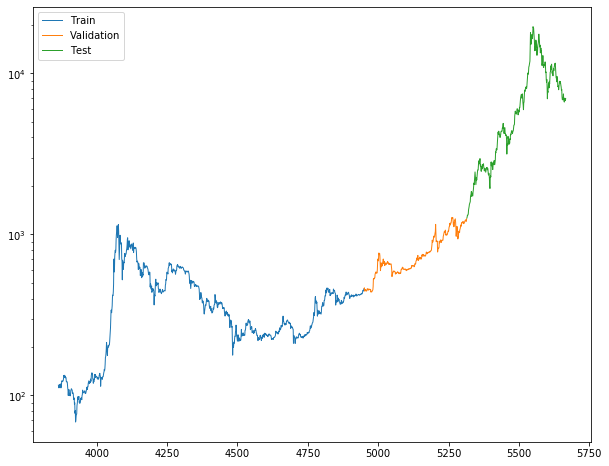

In [310]:
# params['figure.figsize'] = 10, 8 # width 10, height 8

# ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
# ax = val.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
# ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
# ax.legend(['train', 'dev', 'test'])
# ax.set_xlabel("date")
# ax.set_ylabel("USD")
# ax.set_title("Without scaling")

sym = 'BTC'
plt.figure(figsize=(10,8))

train[train['sym'] == sym]['price'].plot(label='Train', lw=1)
val[val['sym'] == sym]['price'].plot(label='Validation', lw=1)
test[test['sym'] == sym]['price'].plot(label='Test', lw=1)

plt.yscale('log')
plt.legend()
plt.show()

In [278]:
feat = None

In [279]:
cols_to_scale = feat_columns + [TARGET]

In [280]:
# scaler_dict = {}
# train_scaled = pd.DataFrame()

# for sym in SYMBOLS:
#     scaler_train = StandardScaler()
#     sym_train = train.query("sym == @sym")
#     sym_train[cols_to_scale] = scaler_train.fit_transform(sym_train[cols_to_scale])
    
#     train_scaled = pd.concat([train_scaled, sym_train], axis=0)
    
#     scaler_dict[sym] = scaler_train

# train_scaled.sort_values(by=['sym', 'time'], inplace=True)
# train_scaled.reset_index(drop=True, inplace=True)

In [281]:
def scale_col(df, base, col):
    mean = df[base + '_mean']
    std = df[base + '_std']
    std = np.where(std == 0, 0.001, std)
    return (df[col] - mean)/std

In [282]:
train_scaled = train.copy()
for p in properties:
    train_scaled[p] = scale_col(train_scaled, p, p)
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        train_scaled[col_name] = scale_col(train_scaled, p, col_name)

In [283]:
val_scaled = val.copy()
for p in properties:
    val_scaled[p] = scale_col(val_scaled, p, p)
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        val_scaled[col_name] = scale_col(val_scaled, p, col_name)

In [284]:
test_scaled = test.copy()
for p in properties:
    test_scaled[p] = scale_col(test_scaled, p, p)
    
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        test_scaled[col_name] = scale_col(test_scaled, p, col_name)

In [285]:
test_scaled.describe()

,market_cap,price,volume,rank,market_share,age,roi,market_cap_lag_1,market_cap_lag_2,market_cap_lag_3,...,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_lag_4,roi_lag_5,roi_lag_6,roi_lag_7,roi_mean,roi_std
count,13007.000000,1.300700e+04,1.300700e+04,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,...,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000
mean,0.270739,1.679970e-01,6.092668e+03,66.622537,-0.129323,1.851912,-0.000730,0.048943,0.017197,-0.002063,...,2.163436,-0.008858,-0.004928,-0.004355,-0.004699,0.001808,0.011210,0.009822,0.006045,0.109214
std,8.585780,2.021850e+00,2.851716e+05,3129.445036,2.237954,0.059661,1.567497,1.093715,0.865874,0.774281,...,0.134888,0.922142,0.922319,0.926532,0.925193,0.927509,0.929121,0.927949,0.058275,0.131429
min,-18.753049,-1.115415e+01,-7.922857e+05,-89426.540288,-12.715254,0.878310,-17.418439,-2.246479,-2.192674,-2.202570,...,2.160247,-2.257281,-2.252014,-2.255698,-2.232111,-2.217908,-2.225340,-2.212337,-0.293394,0.002964
25%,-0.980566,-9.616326e-01,-8.722231e-01,-0.377964,-1.268290,1.851640,-0.719682,-0.846917,-0.664355,-0.548209,...,2.160247,-0.649406,-0.662666,-0.677918,-0.678834,-0.672873,-0.665673,-0.646577,-0.019002,0.055748
50%,0.013138,-9.578925e-08,-3.563138e-01,0.347013,-0.408264,1.851640,-0.030504,0.007387,-0.014068,-0.030740,...,2.160247,-0.026439,-0.026806,-0.011559,-0.007699,-0.005522,-0.010338,-0.017433,0.002450,0.084558
75%,1.112692,1.081497e+00,6.155262e-01,1.315335,0.645527,1.851640,0.685076,0.948235,0.691611,0.519800,...,2.160247,0.626531,0.622692,0.655993,0.659165,0.674698,0.676594,0.650309,0.025285,0.127210
max,946.026299,4.205749e+01,2.834043e+07,99555.191430,90.278672,8.332381,32.125677,2.267779,2.258916,2.252378,...,9.416298,2.262815,2.259329,2.259030,2.258160,2.253826,2.253327,2.249147,1.325704,3.442886


In [286]:
test.query('sym == "ETH"')[[col for col in test.columns if 'price' in col]]

,price,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6,price_lag_7,price_mean,price_std
13653,49.89,50.03,48.49,48.55,48.22,49.67,48.31,50.71,49.140000,0.986898
13654,52.72,49.89,50.03,48.49,48.55,48.22,49.67,48.31,49.022857,0.800556
13655,62.17,52.72,49.89,50.03,48.49,48.55,48.22,49.67,49.652857,1.539900
13656,70.16,62.17,52.72,49.89,50.03,48.49,48.55,48.22,51.438571,4.976359
13657,68.38,70.16,62.17,52.72,49.89,50.03,48.49,48.55,54.572857,8.366116
...,...,...,...,...,...,...,...,...,...,...
14000,385.31,370.29,383.23,380.54,416.89,386.43,379.61,396.46,387.635714,15.111697
14001,400.51,385.31,370.29,383.23,380.54,416.89,386.43,379.61,386.042857,14.605712
14002,398.53,400.51,385.31,370.29,383.23,380.54,416.89,386.43,389.028571,15.195811
14003,414.24,398.53,400.51,385.31,370.29,383.23,380.54,416.89,390.757143,15.535363


In [287]:
test_scaled.query('sym == "ETH"')[[col for col in test_scaled.columns if 'price' in col]]

,price,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6,price_lag_7,price_mean,price_std
13653,0.759957,0.901816,-0.658630,-0.597833,-0.932214,0.537037,-0.841019,1.590844,49.140000,0.986898
13654,4.618217,1.083175,1.258054,-0.665609,-0.590661,-1.002874,0.808366,-0.890452,49.022857,0.800556
13655,8.128545,1.991781,0.153999,0.244914,-0.755151,-0.716188,-0.930487,0.011132,49.652857,1.539900
13656,3.762074,2.156482,0.257503,-0.311186,-0.283053,-0.592516,-0.580459,-0.646772,51.438571,4.976359
13657,1.650365,1.863128,0.908085,-0.221472,-0.559741,-0.543007,-0.727083,-0.719911,54.572857,8.366116
...,...,...,...,...,...,...,...,...,...,...
14000,-0.153902,-1.147834,-0.291543,-0.469551,1.935870,-0.079787,-0.531093,0.583937,387.635714,15.111697
14001,0.990513,-0.050176,-1.078541,-0.192586,-0.376761,2.111992,0.026506,-0.440434,386.042857,14.605712
14002,0.625266,0.755565,-0.244710,-1.233141,-0.381590,-0.558613,1.833494,-0.171006,389.028571,15.195811
14003,1.511574,0.500333,0.627784,-0.350629,-1.317455,-0.484517,-0.657670,1.682153,390.757143,15.535363


In [288]:
train_X = train_scaled[feat_columns]
train_Y = train_scaled[[TARGET]]

# trainval_X = trainval_scaled[feat_columns]
# trainval_Y = trainval_scaled[[TARGET]]

val_X = val_scaled[feat_columns]
val_Y = val_scaled[[TARGET]]

test_X = test_scaled[feat_columns]
test_Y = test_scaled[[TARGET]]

<h2> Training </h2>

In [289]:
prefix = 'xgboost-new'

pd.concat([train_Y, train_X], axis=1).to_csv(os.path.join(DATA_DIR, 'train.csv'), header=False, index=False)
pd.concat([val_Y, val_X], axis=1).to_csv(os.path.join(DATA_DIR, 'val.csv'), header=False, index=False)

train_location = session.upload_data(os.path.join(DATA_DIR, 'train.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(DATA_DIR, 'val.csv'), key_prefix=prefix)

train_input = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
val_input = sagemaker.s3_input(s3_data=val_location, content_type='text/csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [290]:
container = get_image_uri(session.boto_region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# xgb.set_hyperparameters(max_depth=3,
#                         eta=0.1,
#                         gamma=0.1,
#                         min_child_weight=15,
#                         subsample=0.8,
#                         objective='reg:linear',
#                         early_stopping_rounds=10,
#                         num_round=200)
# xgb.set_hyperparameters(max_depth=10,
#                         eta=0.1,
#                         gamma=0.1,
#                         min_child_weight=15,
#                         subsample=0.8,
#                         objective='reg:linear',
#                         early_stopping_rounds=20,
#                         num_round=200)
xgb.set_hyperparameters(max_depth=10,
                        eta=0.1,
                        gamma=0.2,
                        min_child_weight=15,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=20,
                        num_round=200)

xgb.fit({'train': train_input, 'validation': val_input})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-02-02 19:15:15 Starting - Starting the training job...
2021-02-02 19:15:17 Starting - Launching requested ML instances......
2021-02-02 19:16:39 Starting - Preparing the instances for training......
2021-02-02 19:17:34 Downloading - Downloading input data...
2021-02-02 19:18:10 Training - Training image download completed. Training in progress..Arguments: train
[2021-02-02:19:18:11:INFO] Running standalone xgboost training.
[2021-02-02:19:18:11:INFO] File size need to be processed in the node: 35.16mb. Available memory size in the node: 8426.76mb
[2021-02-02:19:18:11:INFO] Determined delimiter of CSV input is ','
[19:18:11] S3DistributionType set as FullyReplicated
[19:18:11] 25788x49 matrix with 1263612 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-02-02:19:18:11:INFO] Determined delimiter of CSV input is ','
[19:18:11] S3DistributionType set as FullyReplicated
[19:18:11] 13847x49 matrix with 678503 entries loaded from /opt/ml/input/data

In [291]:
predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

<h2> Predicting on Test Set </h2>

In [292]:
pred_Y = [predictor.predict(batch).decode('utf-8') for batch in np.array_split(test_X.values, 100)]
pred_Y = [ast.literal_eval(batch) for batch in pred_Y]
pred_Y = np.array([val for sublist in pred_Y for val in sublist])

In [293]:
sym = 'BTC'
pred_mean = test_scaled[TARGET+'_mean']
pred_std = test_scaled[TARGET+'_std']
pred = (pred_Y * pred_std) + pred_mean
# pred = pred_Y

In [294]:
test_result = test.copy()
test_result['pred'] = pred
test_result = test_result.set_index('time')

In [295]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [296]:
get_mape(test_result[TARGET], test_result['pred'])

3.0878256649950675

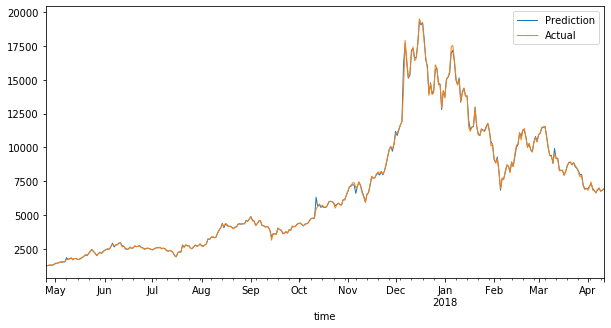

In [297]:
plt.figure(figsize=(10,5))

test_result[test_result['sym'] == sym]['pred'].plot(label='Prediction', lw=1)
test_result[test_result['sym'] == sym][TARGET].plot(label='Actual', lw=1)

plt.legend()
plt.show()

<h2> Predicting on Train Set </h2>

In [298]:
pred_Y = [predictor.predict(batch).decode('utf-8') for batch in np.array_split(train_X.values, 100)]
pred_Y = [ast.literal_eval(batch) for batch in pred_Y]
pred_Y = np.array([val for sublist in pred_Y for val in sublist])

In [299]:
sym = 'BTC'
# pred_mean = train[TARGET+'_mean']
# pred_std = train[TARGET+'_std']
# pred_mean = scler_dict['ETH'].var_[-1]
# pred = pred_Y * math.sqrt(scaler_train.var_[-1]) + scaler_train.mean_[-1]
# pred = pred_Y * pred_std + pred_mean
pred = pred_Y

In [300]:
train_result = train_scaled.copy()
train_result['pred'] = pred
train_result = train_result.set_index('time')

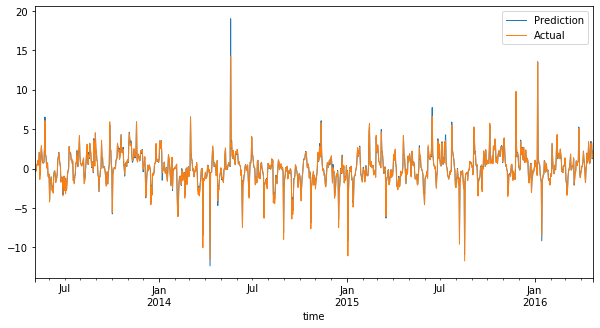

In [301]:
plt.figure(figsize=(10,5))

train_result[train_result['sym'] == sym]['pred'].plot(label='Prediction', lw=1)
train_result[train_result['sym'] == sym][TARGET].plot(label='Actual', lw=1)

plt.legend()
plt.show()

In [305]:
predictor.delete_endpoint()

<h2> Trading </h2>

In [302]:
def update_mean(mean, t, new_value):
    if t == 0:
        return new_value
    else:
        return (mean * (t - 1) + new_value) / t

# Function to update standard deviation based on new value
def update_std(std, mean, new_mean, t, new_value):
    if t == 0:
        return 0
    else:
        return np.sqrt((std ** 2 * (t - 1) + (new_value - new_mean) * (new_value - mean)) / t)

In [303]:
# Function to execute the trading strategy over the trading horizon using asset matrix
def evaluate_strategy(result, target, n=10, initial_value=10000):
    total_value = initial_value
    mean_roi = 0
    std_roi = 0
    
    value_history = []
    roi_history = []
    
    t = 1

    dates = list(set(result.index))
    dates.sort()
    
    df = result.copy()
    if target == 'price':
        df['predicted_roi'] = (df['pred']/df['price_lag_1']) - 1
    else:
        df['predicted_roi'] = df['pred']
    df.sort_values(by='predicted_roi', ascending=False, inplace=True)

    for date in dates:
        temp_df = df.query('time == @date & predicted_roi > 0')

        if not temp_df.empty:
            top_n = temp_df.nlargest(n, 'predicted_roi')
            selected_n = len(top_n)
            day_return = sum(top_n['roi'] * total_value / selected_n)
            day_roi = day_return/total_value
        else:
            day_return = 0
            day_roi = 0
        
        total_value += day_return
        percent_returns = (total_value/initial_value - 1) * 100

        prev_mean_roi = mean_roi
        mean_roi = update_mean(prev_mean_roi, t, day_roi)
        std_roi = update_std(std_roi, prev_mean_roi, mean_roi, t, day_roi)
        sharpe_ratio = mean_roi/std_roi
        
        value_history.append(total_value)
        roi_history.append(day_roi)

        t += 1
        
    print('Cumulative Returns: {:.2e}%'.format(percent_returns))
    
    history = pd.concat([pd.DataFrame(dates), pd.DataFrame(value_history), pd.DataFrame(roi_history)], axis=1)
    history.columns = ['time', 'total_value', 'roi']
    history = history.set_index('time')
    return sharpe_ratio, percent_returns, history

In [304]:
result = evaluate_strategy(test_result, TARGET)

Cumulative Returns: 2.10e+06%


In [ ]:
import boto3
client = boto3.client('sagemaker')
training_job = str(tuner.best_training_job())
client.describe_training_job(TrainingJobName=training_job)['HyperParameters']

import os
import tarfile
import pickle as pkl
import sagemaker.xgb as xgboost
key = os.path.join(name, 'output', training_job, 'output/model.tar.gz')
print(key)
boto3.resource('s3').Bucket(xgb_optim.bucket).download_file(key, './results/model.tar.gz')
# os.system('tar -zxvf ./results/model.tar.gz')
# os.system('unzip ./results/model_algo-1 -d ./results')
tar = tarfile.open('./results/model.tar.gz')
tar.extractall()
tar.close()

import os
import tarfile
import pickle as pkl
import sagemaker.xgb as xgboost
key = os.path.join(name, 'output', training_job, 'output/model.tar.gz')
print(key)
boto3.resource('s3').Bucket(xgb_optim.bucket).download_file(key, './results/model.tar.gz')
# os.system('tar -zxvf ./results/model.tar.gz')
# os.system('unzip ./results/model_algo-1 -d ./results')
tar = tarfile.open('./results/model.tar.gz')
tar.extractall()
tar.close()
!pip install xgboost==1.0.1
import joblib
_fil = open('xgboost-model', 'rb')

# map_names = dict(zip(model.feature_names, train_data[cols_input].columns))
# model.feature_names = list(map_names.values())

# #plot feature importance
# fig, ax = plt.subplots(figsize=(12,12))
# xgb_optim.model.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
# plt.title('Feature Importance')
# plt.show()
model = pkl.load(open('./results/model', 'rb'))
# map_names = dict(zip(model.feature_names, train_data[cols_input].columns))
# model.feature_names = list(map_names.values())

# #plot feature importance
# fig, ax = plt.subplots(figsize=(12,12))
# xgb_optim.model.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
# plt.title('Feature Importance')
# plt.show()
#https://towardsdatascience.com/xgboost-in-amazon-sagemaker-28e5e354dbcd


